In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("food101", split="train", with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.C9SXBO_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.C9SXBO_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    as_supervised=True,
    with_info=True
)


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    split

In [ ]:
IMG_SIZE = 224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(ds_info.features["label"].num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test
)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 255s 97ms/step - accuracy: 0.3639 - loss: 2.6728 - val_accuracy: 0.5442 - val_loss: 1.7162
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 76ms/step - accuracy: 0.5419 - loss: 1.7843 - val_accuracy: 0.5571 - val_loss: 1.6672
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 76ms/step - accuracy: 0.5872 - loss: 1.5773 - val_accuracy: 0.5569 - val_loss: 1.6888
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 180s 76ms/step - accuracy: 0.6261 - loss: 1.4102 - val_accuracy: 0.5571 - val_loss: 1.7213
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 178s 75ms/step - accuracy: 0.6598 - loss: 1.2758 - val_accuracy: 0.5474 - val_loss: 1.8034


In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(ds_train, epochs=3, validation_data=ds_test)

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 386s 141ms/step - accuracy: 0.3969 - loss: 2.5464 - val_accuracy: 0.5761 - val_loss: 1.6422
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 299s 126ms/step - accuracy: 0.6067 - loss: 1.4914 - val_accuracy: 0.6214 - val_loss: 1.4542
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 298s 126ms/step - accuracy: 0.6864 - loss: 1.1784 - val_accuracy: 0.6377 - val_loss: 1.3898


In [4]:
def predict_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = np.argmax(prediction)

    class_names = ds_info.features["label"].names
    return class_names[predicted_label]

In [3]:
calorie_dict = {
    "pizza": 266,
    "hamburger": 295,
    "french_fries": 312,
    "ice_cream": 207,
    "salad": 150,
    "apple": 52,
    "banana": 89,
    "orange": 47,
    "broccoli": 34,
    "carrot": 41,
    "cauliflower": 25,
    "corn": 121,
    "cucumber": 15,
    "eggplant": 25,
    "grapes": 60
    }

In [6]:
from google.colab import files
uploaded = files.upload()

Saving pizza.jpg to pizza.jpg


In [7]:
food = predict_image("pizza.jpg")

NameError: name 'tf' is not defined

In [ ]:
food = predict_image(list(uploaded.keys())[0])
calories = calorie_dict.get(food, "Not Available")

print("Food:", food)
print("Estimated Calories:", calories)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Food: pizza
Estimated Calories: 266


In [ ]:
portion = input("Enter portion size (small/medium/large): ")

if portion == "small":
    calories *= 0.75
elif portion == "large":
    calories *= 1.3

In [ ]:
portion = input("Enter portion size (small/medium/large): ")

if portion == "small":
    calories *= 0.75
elif portion == "large":
    calories *= 1.3

Enter portion size (small/medium/large): small


In [ ]:
model.save("food_calorie_model.h5")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━

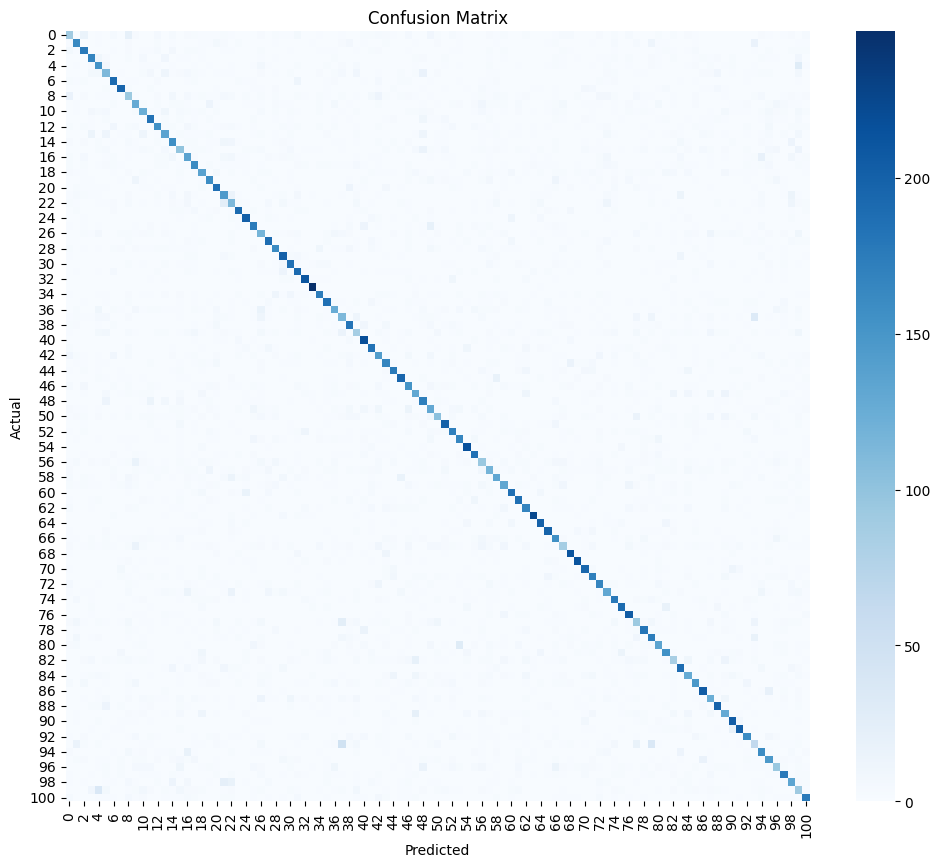

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(
    y_true,
    y_pred,
    target_names=ds_info.features["label"].names
))

                         precision    recall  f1-score   support

              apple_pie       0.43      0.36      0.39       250
         baby_back_ribs       0.67      0.65      0.66       250
                baklava       0.66      0.71      0.69       250
         beef_carpaccio       0.69      0.67      0.68       250
           beef_tartare       0.53      0.61      0.57       250
             beet_salad       0.48      0.45      0.46       250
               beignets       0.73      0.76      0.75       250
               bibimbap       0.80      0.78      0.79       250
          bread_pudding       0.37      0.37      0.37       250
      breakfast_burrito       0.52      0.51      0.52       250
             bruschetta       0.55      0.50      0.52       250
           caesar_salad       0.68      0.73      0.71       250
                cannoli       0.72      0.62      0.67       250
          caprese_salad       0.59      0.54      0.56       250
            carrot_cake 